In [1]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.feature_selection import f_regression

In [4]:
import sys
import os
from os.path import dirname

UTILS_PATH=os.environ.get('REPO') + "/notebooks/commons"
sys.path.append(dirname(UTILS_PATH))

from commons import check_args, gen_paths, coordinates_bounds, plot_feature_importances

In [5]:
def load_posts(input_path):
    df = pd.read_parquet(input_path)
    return df

In [6]:
if __name__ == "__main__":
    city = "manizales"
    property_type = "casas"
    post_type = "arriendo"
    
    #city, property_type, post_type = check_args()
    base_path = os.environ.get('REPO')

    raw_path, clean_path = gen_paths(city, property_type, post_type)
    
    raw_path = base_path + raw_path
    clean_path = base_path + clean_path

In [7]:
MSG = """
Hay {} publicaciones de {} en total
"""

posts = load_posts(clean_path)
print(MSG.format(posts.shape[0], post_type))
posts.head()


Hay 99 publicaciones de arriendo en total



,surface,rooms,baths,garages,price,latitude,description,longitude,location,url,admon,estrato,antiguedad,fid,city,property_type,post_type,price_m2
0,486.0,4.0,4.0,0.0,4.86,5.068640,"Área de 486 mtrs, 4 baños, cocina sencilla, cu...",-75.517929,Manizales CENTRO,https://www.fincaraiz.com.co/casa-en-arriendo/...,0.0,4.0,16 a 30,3078558,manizales,casas,arriendo,0.010000
1,110.0,3.0,3.0,0.0,4.00,5.062479,"Área de 110 mtrs, 3 alcobas, 3 closet, 3 baños...",-75.495445,Manizales EL TRIANGULO,https://www.fincaraiz.com.co/casa-en-arriendo/...,0.0,6.0,16 a 30,3497615,manizales,casas,arriendo,0.036364
2,1.0,5.0,4.0,0.0,3.00,5.058675,"5 alcobas, closet, 4 baños, sala comedor, coci...",-75.488083,Manizales PALOGRANDE,https://www.fincaraiz.com.co/casa-en-arriendo/...,0.0,6.0,16 a 30,5619086,manizales,casas,arriendo,3.000000
3,330.0,7.0,4.0,0.0,3.00,5.068990,"Para comercial consta de 7 alcobas, 4 baños, c...",-75.517342,Manizales centro,https://www.fincaraiz.com.co/casa-en-arriendo/...,0.0,4.0,desconocido,5594083,manizales,casas,arriendo,0.009091
4,120.0,4.0,3.0,1.0,1.55,5.035938,Administra Bienes Raíces ofrece amplia e ilumi...,-75.469330,Manizales San Marcel,https://www.fincaraiz.com.co/casa-en-arriendo/...,0.0,6.0,desconocido,4430438,manizales,casas,arriendo,0.012917


## Es necesario cambiar la representación de algunas de las columnas


In [8]:
## La antiguedad tiene 5 posibles valores pero se representa con un string, la idea es usar un entero en cambio

antiguedades = posts["antiguedad"].value_counts().index
new_antiguedades = {}
for i in range(len(antiguedades)):
    new_antiguedades[antiguedades[i]] = i
new_antiguedades

{'16 a 30': 0, 'desconocido': 1, '9 a 15': 2, 'Más de 30': 3, '1 a 8': 4}

In [9]:
posts.loc[:, "antiguedad"] = posts["antiguedad"].apply(lambda e: new_antiguedades[e])

In [10]:
## Las features y las etiquetas son las mismas en todos los métodos

FEATURES = [
    'surface', 'rooms', 
    'baths', 'garages', 'latitude', 
    'longitude', 'admon', 
    'estrato','antiguedad'
]

LABEL = "price"

X = posts[FEATURES].values
y = posts[LABEL].values

## Selección de features univariada

In [11]:
selector = SelectKBest(f_regression, k=5)
X_new = selector.fit_transform(X, y)
X_new.shape

(99, 5)

In [12]:
feature_importances = pd.DataFrame({'importance': selector.scores_, 'feature': FEATURES})

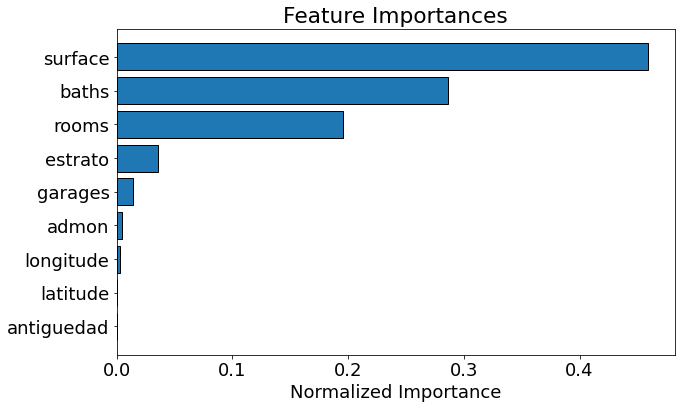

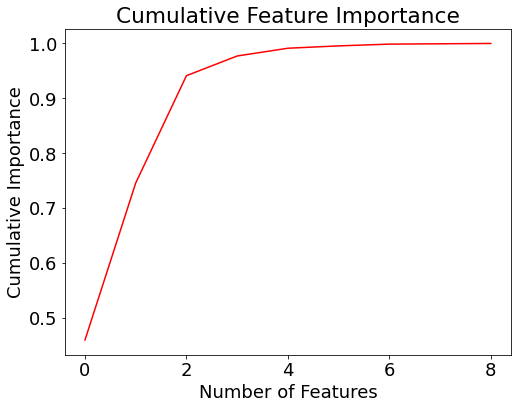

3 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,0,167.545727,surface,0.459090,0.459090
1,2,104.496270,baths,0.286329,0.745419
2,1,71.464777,rooms,0.195820,0.941239
3,7,13.106963,estrato,0.035914,0.977153
4,3,5.158150,garages,0.014134,0.991287
5,6,1.572486,admon,0.004309,0.995596
6,5,1.165260,longitude,0.003193,0.998789
7,4,0.228087,latitude,0.000625,0.999414
8,8,0.213896,antiguedad,0.000586,1.000000


In [13]:
plot_feature_importances(feature_importances)

## Eliminación recursiva de features

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [15]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.7381317650220243

In [16]:
rfe = RFE(estimator=reg, n_features_to_select=1, step=1)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=1)

In [17]:
feature_importances = pd.DataFrame({'importance': rfe.ranking_, 'feature': FEATURES})

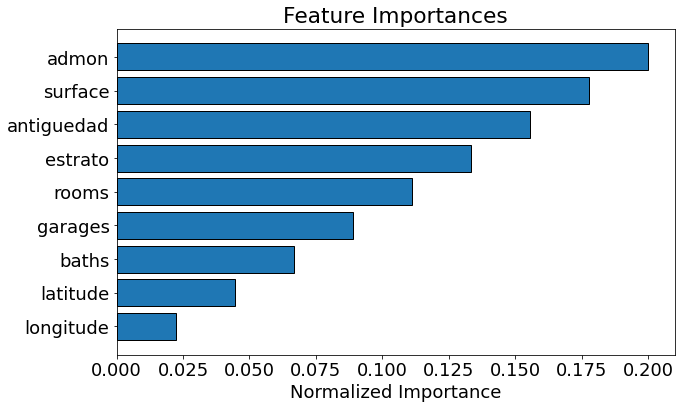

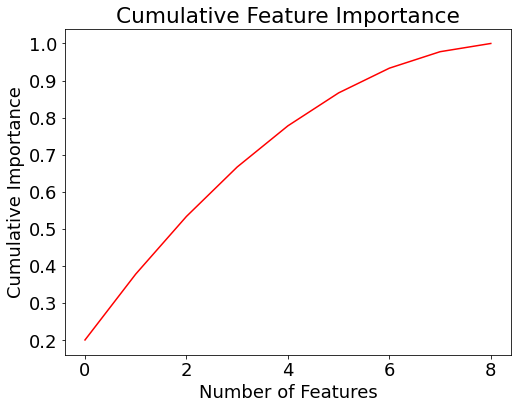

7 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,6,9,admon,0.200000,0.200000
1,0,8,surface,0.177778,0.377778
2,8,7,antiguedad,0.155556,0.533333
3,7,6,estrato,0.133333,0.666667
4,1,5,rooms,0.111111,0.777778
5,3,4,garages,0.088889,0.866667
6,2,3,baths,0.066667,0.933333
7,4,2,latitude,0.044444,0.977778
8,5,1,longitude,0.022222,1.000000


In [18]:
plot_feature_importances(feature_importances)

## Selección de features basada en arboles

In [19]:
from sklearn.ensemble import ExtraTreesRegressor

In [20]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0)
forest.fit(X, y)

ExtraTreesRegressor(random_state=0)

In [21]:
feature_importances = pd.DataFrame({'importance':  forest.feature_importances_, 'feature': FEATURES})

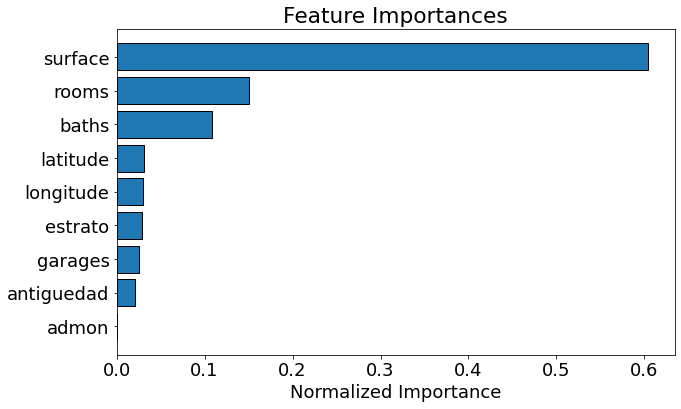

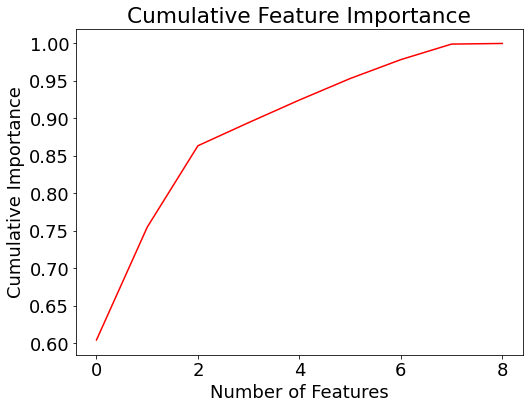

5 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,0,0.604046,surface,0.604046,0.604046
1,1,0.150622,rooms,0.150622,0.754668
2,2,0.108762,baths,0.108762,0.863430
3,4,0.030904,latitude,0.030904,0.894334
4,5,0.030166,longitude,0.030166,0.924500
5,7,0.028656,estrato,0.028656,0.953156
6,3,0.025274,garages,0.025274,0.978430
7,8,0.020747,antiguedad,0.020747,0.999177
8,6,0.000823,admon,0.000823,1.000000


In [22]:
plot_feature_importances(feature_importances)